# Load modules

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os

import scanpy as sc
import squidpy as sq

import scipy

from sklearn.preprocessing import LabelBinarizer

import warnings
warnings.filterwarnings("ignore")

In [7]:
directory = '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231020__200939__BT2126_BT1745/Neighborhood'
if not os.path.exists(directory):
    os.makedirs(directory)

# Concatenate samples

In [5]:
# Create a color palette for each unique Metaprogram
metaprogram_names = ["Cycling", "Neuroepithelial-like", "Radial glia-like", 
                          "NPC-like" ,"Ependymal-like", "Mesenchymal", "Unassigned", 
                          "T-cell", "Myeloid", "Microglia", "Endothelial", "Neurons", "VLMCs", "Oligodendrocytes"]

metaprogram_colors = ["gray30","#F99E93FF","#9E5E9BFF","#74ADD1FF","#ACD39EFF","#96410EFF", 'grey80',
                   '#BDA14DFF', '#3EBCB6FF', '#0169C4FF', '#153460FF', '#D5114EFF' ,'#A56EB6FF' ,'#4B1C57FF']

metaprogram_to_color = dict(zip(metaprogram_names, metaprogram_colors))


samples = [ '0010652__Region_4']

metadata = ['/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231020__200939__BT2126_BT1745/data/individual/cell_ID_0010652-Region_4.csv']

anndata_list = []
for i in range(len(samples)):
    adata = sc.read_10x_h5(filename = '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231020__200939__BT2126_BT1745/output-XETG00083__'+samples[i]+'__20231020__201259/cell_feature_matrix.h5')
    df = pd.read_csv('/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231020__200939__BT2126_BT1745/output-XETG00083__'+samples[i]+'__20231020__201259/cells.csv.gz')

    df.set_index(adata.obs_names, inplace=True)
    adata.obs = df.copy()

    adata.obsm["spatial"] = np.array([adata.obs.x_centroid*0.325, adata.obs.y_centroid*0.325]).transpose().astype('float64')

    anno = pd.read_csv(metadata[i], index_col = 0)
    if 'X' in anno.columns:
        anno.index = anno['X']
    
    adata = adata[anno.index,:]
    
    adata.obs['Metaprogram'] = anno['group']
    adata.obs['Metaprogram'] = adata.obs['Metaprogram'].astype('category')
    adata.obs['sample'] = samples[i]

    # Add the color information to the AnnData object
    adata.uns['Metaprogram_colors'] = metaprogram_to_color
    
    anndata_list.append(adata)
    
    print(samples[i])

adata = sc.concat(anndata_list) 


0010652__Region_4


# Plot spatial neighbors for each sample

0010652__Region_4


<Figure size 1000x1000 with 0 Axes>

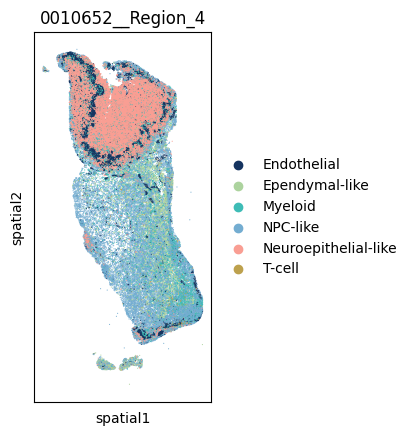

<Figure size 640x480 with 0 Axes>

In [8]:
for samp in adata.obs['sample'].unique():
    asub=adata[adata.obs['sample']==samp]
    print(samp)
    
    plt.figure(figsize=(10,10))
    sc.pl.spatial(
    asub,
    color="Metaprogram",
    title = samp,
    palette = metaprogram_to_color,
    neighbors_key="spatial_neighbors",
    spot_size=10,
    size = 0.8,
    edges=False,
    edges_width=2,
    img_key=None)

    plt.savefig(directory+f"/1_Spatial_{samp}.png", dpi = 600)

In [9]:
np.unique(adata.obs['Metaprogram'])

array(['Endothelial', 'Ependymal-like', 'Myeloid', 'NPC-like',
       'Neuroepithelial-like', 'T-cell'], dtype=object)

In [10]:
ad = adata

# Calculate spatial data for each sample

In [12]:
anndata_list = []
for sample in ad.obs['sample'].unique():
    adata_copy_int = ad[ad.obs['sample'] == sample ]
    adata_copy_int.obs.index = list(pd.DataFrame(list((adata_copy_int.obs['sample'])))[0] +'_' +pd.DataFrame(list((adata_copy_int.obs.index)))[0])
    sq.gr.spatial_neighbors(adata_copy_int, coord_type = 'generic', radius = 70.0)
        
    #lb = LabelBinarizer(sparse_output=True)
    #grouped = lb.fit_transform(adata_copy_int.obs['Metaprogram']).T.dot((adata_copy_int.obsp['spatial_distances']>0)*1)
    #neighmatrix = pd.DataFrame(data = scipy.sparse.csr_matrix.todense(grouped)).transpose()
    #neighmatrix.set_axis(sorted(adata_copy_int.obs['Metaprogram'].unique()), axis="columns", inplace=True)
    
    #datf = pd.DataFrame(data = scipy.sparse.csr_matrix.todense((adata_copy_int.obsp['spatial_distances']>0)*1))
    #datf['key'] = list(adata_copy_int.obs['Metaprogram'])
    #neighmatrix = datf.groupby('key').sum().transpose()
    
    if len(adata_copy_int.obs.groupby('Metaprogram').size()) == 2:
        datf = pd.DataFrame(data = scipy.sparse.csr_matrix.todense((adata_copy_int.obsp['spatial_distances']>0)*1))
        datf['key'] = list(adata_copy_int.obs['Metaprogram'])
        neighmatrix = datf.groupby('key').sum().transpose()
    else:
        lb = LabelBinarizer(sparse_output=True)
        grouped = lb.fit_transform(adata_copy_int.obs['Metaprogram'].to_numpy()).T.dot((adata_copy_int.obsp['spatial_distances']>0)*1)
        neighmatrix = pd.DataFrame(data = scipy.sparse.csr_matrix.todense(grouped)).transpose()
        neighmatrix.set_axis(sorted(adata_copy_int.obs['Metaprogram'].unique()), axis = "columns", copy = False)
    
    adataneigh = sc.AnnData(neighmatrix)
    adataneigh.obs = adata_copy_int.obs
    adataneigh.obs['counts'] = list(np.sum(neighmatrix,axis=1))
    # added from Sara (otherwise error about missing spatial coordinates)
    adataneigh.obsm["spatial"] = np.array([adataneigh.obs.x_centroid*0.325, adataneigh.obs.y_centroid*0.325]).transpose().astype('float64')

    anndata_list.append(adataneigh)
    print(sample)

0010652__Region_4


Calculating spatial scores for 0010652__Region_4
ERROR: Unable to fetch palette, reason: 'Metaprogram_colors'. Using `None`.


<Figure size 1600x400 with 0 Axes>

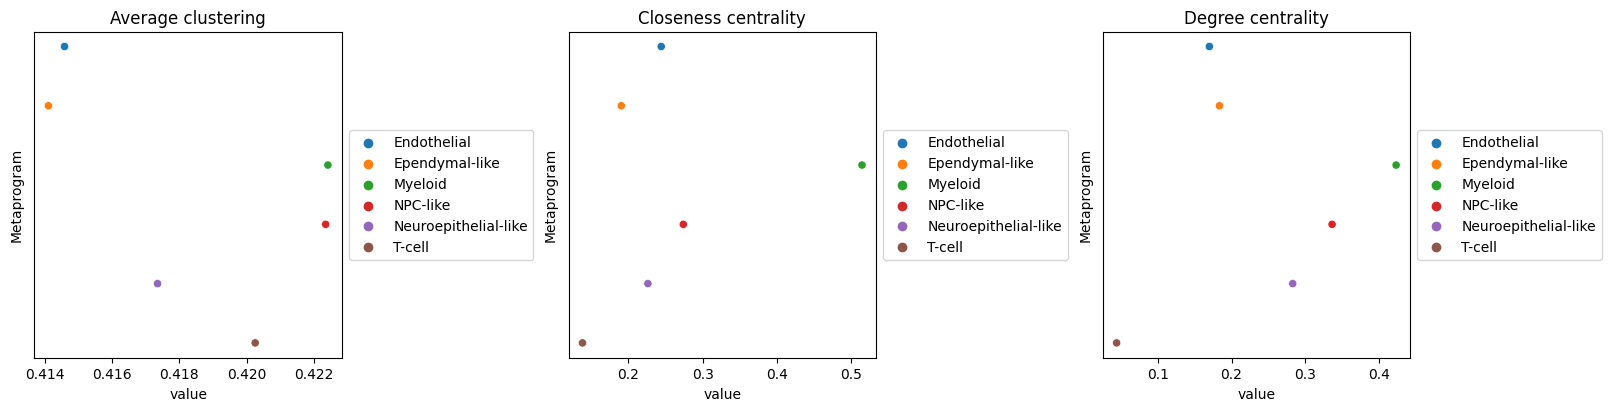

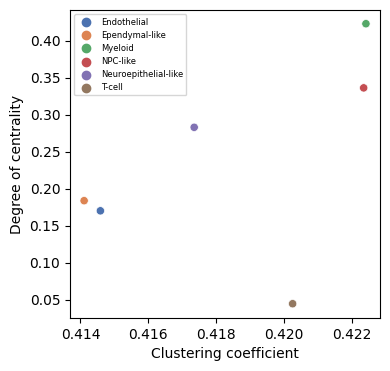

In [13]:
anndata_list = []
for sample in ad.obs['sample'].unique():
    adata_copy_int = ad[ad.obs['sample'] == sample ]
    adata_copy_int.obs.index = list(pd.DataFrame(list((adata_copy_int.obs['sample'])))[0] +'_' +pd.DataFrame(list((adata_copy_int.obs.index)))[0])
    sq.gr.spatial_neighbors(adata_copy_int, coord_type = 'generic', radius = 70.0)
    
    if len(adata_copy_int.obs.groupby('Metaprogram').size()) == 2:
        datf = pd.DataFrame(data = scipy.sparse.csr_matrix.todense((adata_copy_int.obsp['spatial_distances']>0)*1))
        datf['key'] = list(adata_copy_int.obs['Metaprogram'])
        neighmatrix = datf.groupby('key').sum().transpose()
    else:
        lb = LabelBinarizer(sparse_output=True)
        grouped = lb.fit_transform(adata_copy_int.obs['Metaprogram'].to_numpy()).T.dot((adata_copy_int.obsp['spatial_distances']>0)*1)
        neighmatrix = pd.DataFrame(data = scipy.sparse.csr_matrix.todense(grouped)).transpose()
        neighmatrix.set_axis(sorted(adata_copy_int.obs['Metaprogram'].unique()), axis = "columns", copy = False)
    
    adataneigh = sc.AnnData(neighmatrix)
    adataneigh.obs = adata_copy_int.obs
    adataneigh.obs['counts'] = list(np.sum(neighmatrix,axis=1))
    # added from Sara
    adataneigh.obsm["spatial"] = np.array([adataneigh.obs.x_centroid*0.325, adataneigh.obs.y_centroid*0.325]).transpose().astype('float64')

    
    print(f"Calculating spatial scores for {sample}")

    plt.figure(figsize=(16, 4))
    sq.gr.spatial_neighbors(adataneigh, coord_type = "generic", delaunay = True)
    sq.gr.centrality_scores(adataneigh, cluster_key = "Metaprogram")
    sq.pl.centrality_scores(adataneigh, 
                            cluster_key = "Metaprogram", figsize=(16, 4))
    plt.savefig(directory+f"/2_clustering_closeness_centrality_{sample}.pdf")

    dt = adataneigh.uns['Metaprogram_centrality_scores']
    dt['Metaprogram'] = dt.index

    plt.figure(figsize=(4, 4))
    pt = sns.scatterplot(data = dt, x = "average_clustering", y = "degree_centrality", hue = "Metaprogram", palette = "deep")
    pt.set(xlabel = 'Clustering coefficient', ylabel = 'Degree of centrality')
    pt.legend(fontsize = 6)
    plt.savefig(directory+f"/3_centrality_scores_{sample}.pdf")
    plt.show()

    df = adataneigh.uns['Metaprogram_centrality_scores']
    df.to_csv(directory+f'/4_centrality_scores_{sample}.csv')

    anndata_list.append(adataneigh)


In [14]:
ad.obs['sample'].unique()

array(['0010652__Region_4'], dtype=object)

# Neighbors enrichment analysis

  0%|          | 0/1000 [00:00<?, ?/s]

<Figure size 800x400 with 0 Axes>

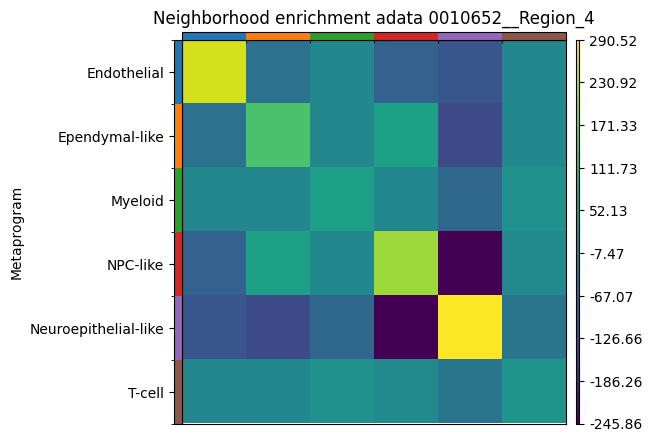

In [15]:
for sample in ad.obs['sample'].unique():
    for anndata in anndata_list:
        if anndata.obs['sample'].unique()[0] == sample:
            adataneigh = anndata
            sq.gr.nhood_enrichment(adataneigh, cluster_key = "Metaprogram", seed = 1234)
           
            # plot figure
            plt.figure(figsize=(8, 4))
            sq.pl.nhood_enrichment(
            adataneigh,
            cluster_key = "Metaprogram",
            figsize = (8, 4),
            title = f"Neighborhood enrichment adata {sample}"
            )
            plt.savefig(directory+f"/4_Neighborhood_enrichment_{sample}.png", dpi=600)

            # save scores
            df_zscore = pd.DataFrame(adataneigh.uns['Metaprogram_nhood_enrichment']['zscore'])
            df_counts = pd.DataFrame(adataneigh.uns['Metaprogram_nhood_enrichment']['count'])
            
            df_zscore.to_csv(directory+f"/5_Neighborhood_enrichment_zscore_{sample}.csv")
            df_counts.to_csv(directory+f"/5_Neighborhood_enrichment_counts_{sample}.csv")